In [1]:
!pip install tensorflow
!pip install matplotlib
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
from tensorflow import keras
import keras.layers
from PIL import Image
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import os
import random
from tensorflow.keras import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
import PIL.Image as Image
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import ResNet50
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_curve
)

In [2]:
def set_random_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
set_random_seeds(42)

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
!unzip gdrive/MyDrive/Dataset.zip

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Archive:  gdrive/MyDrive/Dataset.zip
replace Freshwater Fish Disease Aquaculture in south asia/Test/Bacterial Red disease/Bacterial Red disease (1).jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Freshwater Fish Disease Aquaculture in south asia/Test/Bacterial Red disease/Bacterial Red disease (1).jpeg  
  inflating: Freshwater Fish Disease Aquaculture in south asia/Test/Bacterial Red disease/Bacterial Red disease (1).jpg  
  inflating: Freshwater Fish Disease Aquaculture in south asia/Test/Bacterial Red disease/Bacterial Red disease (1).png  
  inflating: Freshwater Fish Disease Aquaculture in south asia/Test/Bacterial Red disease/Bacterial Red disease (10).jpg  
  inflating: Freshwater Fish Disease Aquaculture in south asia/Test/Bacterial Red disease/Bacterial Red disease (11).jpg  
  inflating: Freshwater Fish Disease Aquaculture in south asia

In [4]:
IMAGE_SIZE=256
BATCH_SIZE=32

In [5]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "Freshwater Fish Disease Aquaculture in south asia/Train",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1747 files belonging to 7 classes.


In [6]:
class_names=dataset.class_names
class_names

['Bacterial Red disease',
 'Bacterial diseases - Aeromoniasis',
 'Bacterial gill disease',
 'Fungal diseases Saprolegniasis',
 'Healthy Fish',
 'Parasitic diseases',
 'Viral diseases White tail disease']

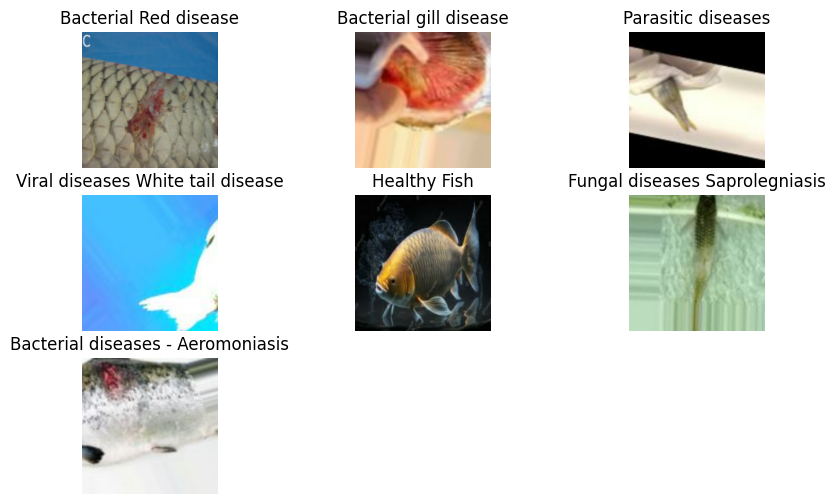

In [7]:
displayed_classes = {}
plt.figure(figsize=(10,6))

for image_batch, label_batch in dataset.take(1):
    i = 0
    for img, label in zip(image_batch, label_batch):
        class_label = label.numpy()

        if class_label not in displayed_classes:
            displayed_classes[class_label] = True
            plt.subplot(3, 3, i + 1)
            plt.imshow(img.numpy().astype("uint8"))
            plt.axis("off")
            plt.title(class_names[class_label])
            i += 1

        if i >= 7:
            break

plt.show()


In [8]:
TRAIN_SIZE, VALIDATION_SIZE= 0.9, 0.1
train_batch = int(len(dataset) * TRAIN_SIZE)
train_imgs = dataset.take(train_batch)
val_batch = int(len(dataset) * VALIDATION_SIZE)
valid_imgs = dataset.skip(train_batch).take(val_batch)

In [9]:
print("Number of Images in Training Dataset {}".format(train_batch*BATCH_SIZE))
print("Number of Images in Validation Dataset {}".format(val_batch*BATCH_SIZE))

Number of Images in Training Dataset 1568
Number of Images in Validation Dataset 160


In [10]:
resize_and_rescale=tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [11]:
import collections


train_class_counts = collections.defaultdict(int)


for images, labels in train_imgs.unbatch():
    train_class_counts[int(labels.numpy())] += 1


print("Training images per category:")
for category, count in train_class_counts.items():
    print(f"Class {category}: {count} images")


Training images per category:
Class 2: 223 images
Class 0: 227 images
Class 6: 226 images
Class 4: 224 images
Class 1: 222 images
Class 5: 224 images
Class 3: 222 images


In [12]:
import collections
data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.05),
    layers.RandomContrast(0.01),
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomBrightness(0.005),
    layers.GaussianNoise(0.005),
    layers.RandomTranslation(0.005, 0.005),
    layers.RandomShear(0.005, 0.005),
    layers.RandomCrop(IMAGE_SIZE, IMAGE_SIZE)
])

def augment_image(image, label):
    augmented_images = [data_augmentation(image, training=True) for _ in range(6)]
    return tf.data.Dataset.from_tensor_slices((augmented_images, [label]*6))

augmented_imgs = train_imgs.unbatch().flat_map(augment_image).batch(BATCH_SIZE)
all_train_imgs = train_imgs.concatenate(augmented_imgs)

all_train_imgs = all_train_imgs.shuffle(1000).prefetch(tf.data.AUTOTUNE)

augmented_count = sum(1 for _ in all_train_imgs.unbatch())
print(f"Total training images after augmentation: {augmented_count}")

train_class_counts = collections.defaultdict(int)
for _, label in all_train_imgs.unbatch():
    train_class_counts[int(label.numpy())] += 1

print("\nTraining images per category after augmentation:")
for category, count in train_class_counts.items():
    print(f"Class {category}: {count} images")

Total training images after augmentation: 10976

Training images per category after augmentation:
Class 5: 1622 images
Class 2: 1547 images
Class 1: 1597 images
Class 0: 1586 images
Class 3: 1523 images
Class 6: 1583 images
Class 4: 1518 images


In [14]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE,IMAGE_SIZE, 3))
base_model.trainable=False
model = tf.keras.Sequential(
    [base_model,
     tf.keras.layers.Flatten(),
     tf.keras.layers.Dense(384,activation='relu'),
     tf.keras.layers.Dense(7, activation='softmax')]
)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
callback = [
    tf.keras.callbacks.ModelCheckpoint(filepath='model.keras')
]
history=model.fit(all_train_imgs, validation_data=valid_imgs, epochs=25,callbacks = callback,batch_size = BATCH_SIZE,verbose=1)

Epoch 1/25
343/343 ━━━━━━━━━━━━━━━━━━━━ 94s 45ms/step - accuracy: 0.4233 - loss: 21.2154 - val_accuracy: 0.7312 - val_loss: 0.7560
Epoch 2/25
343/343 ━━━━━━━━━━━━━━━━━━━━ 79s 31ms/step - accuracy: 0.7244 - loss: 0.8086 - val_accuracy: 0.7688 - val_loss: 0.6010
Epoch 3/25
343/343 ━━━━━━━━━━━━━━━━━━━━ 79s 32ms/step - accuracy: 0.8362 - loss: 0.5322 - val_accuracy: 0.8438 - val_loss: 0.4655
Epoch 4/25
343/343 ━━━━━━━━━━━━━━━━━━━━ 79s 32ms/step - accuracy: 0.8940 - loss: 0.3425 - val_accuracy: 0.9250 - val_loss: 0.1805
Epoch 5/25
343/343 ━━━━━━━━━━━━━━━━━━━━ 80s 32ms/step - accuracy: 0.9267 - loss: 0.2156 - val_accuracy: 0.9187 - val_loss: 0.1641
Epoch 6/25
343/343 ━━━━━━━━━━━━━━━━━━━━ 78s 32ms/step - accuracy: 0.9524 - loss: 0.1481 - val_accuracy: 0.9500 - val_loss: 0.1784
Epoch 7/25
343/343 ━━━━━━━━━━━━━━━━━━━━ 80s 32ms/step - accuracy: 0.9656 - loss: 0.1180 - val_accuracy: 0.9750 - val_loss: 0.0758
Epoch 8/25
343/343 ━━━━━━━━━━━━━━━━━━━━ 79s 32ms/step - accuracy: 0.9664 - loss: 0.1112 -

In [15]:
model.save('model.keras')

In [16]:
test_imgs=tf.keras.preprocessing.image_dataset_from_directory(
    "Freshwater Fish Disease Aquaculture in south asia/Test",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 697 files belonging to 7 classes.


In [17]:
test_count = test_imgs.cardinality().numpy() * BATCH_SIZE
print(f"Total testing images: {test_count}")

Total testing images: 704


In [18]:
all_predictions=[]
all_labels=[]
for images,labels in test_imgs:
  predictions=model.predict(images)
  predicted_classes=np.argmax(predictions,axis=1)
  all_predictions.extend(predicted_classes)
  all_labels.extend(labels.numpy())


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


In [19]:
accuracy = accuracy_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')
precision = precision_score(all_labels, all_predictions, average='weighted')

print("Accuracy: ", accuracy)
print("F1 Score: ", f1)
print("Recall: ", recall)
print("Precision: ", precision)

Accuracy:  0.9971305595408895
F1 Score:  0.9971302725681463
Recall:  0.9971305595408895
Precision:  0.9971868230793034


In [20]:
confusion_matrix(all_labels,all_predictions)

array([[100,   0,   0,   0,   0,   0,   0],
       [  0, 100,   0,   0,   0,   0,   0],
       [  0,   0,  98,   2,   0,   0,   0],
       [  0,   0,   0, 100,   0,   0,   0],
       [  0,   0,   0,   0, 100,   0,   0],
       [  0,   0,   0,   0,   0, 100,   0],
       [  0,   0,   0,   0,   0,   0,  97]])

In [21]:
model = load_model('model.keras')

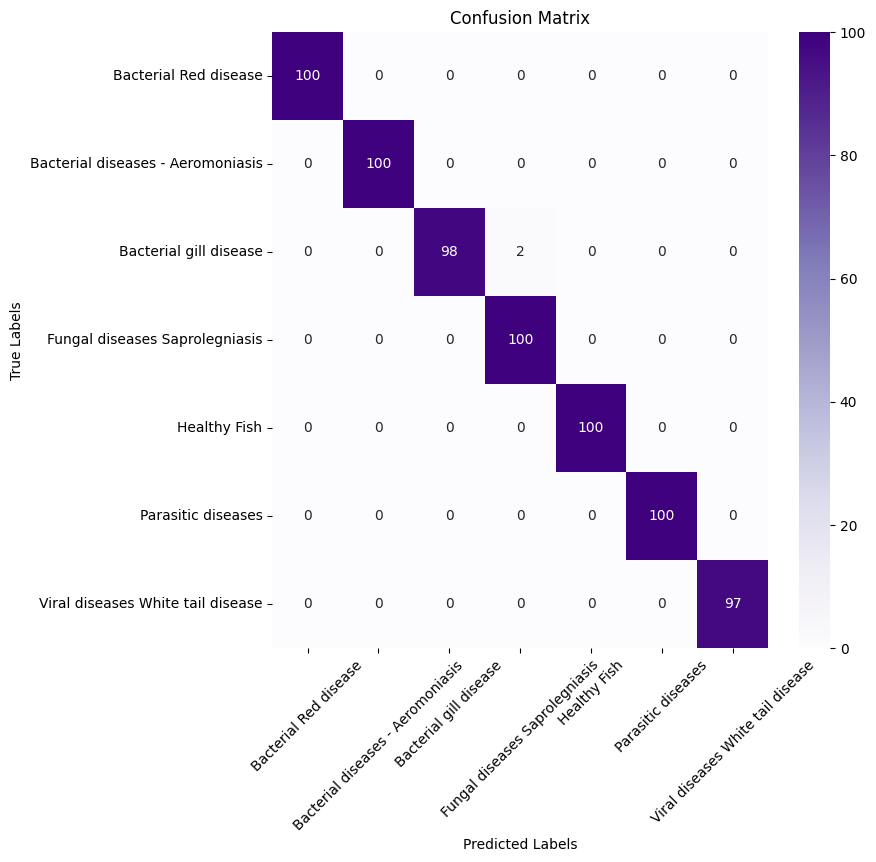

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(all_labels,all_predictions),annot=True,fmt="d",cmap="Purples",xticklabels=class_names,yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.show()

Text(0.5, 1.0, 'Training and Validation Loss')

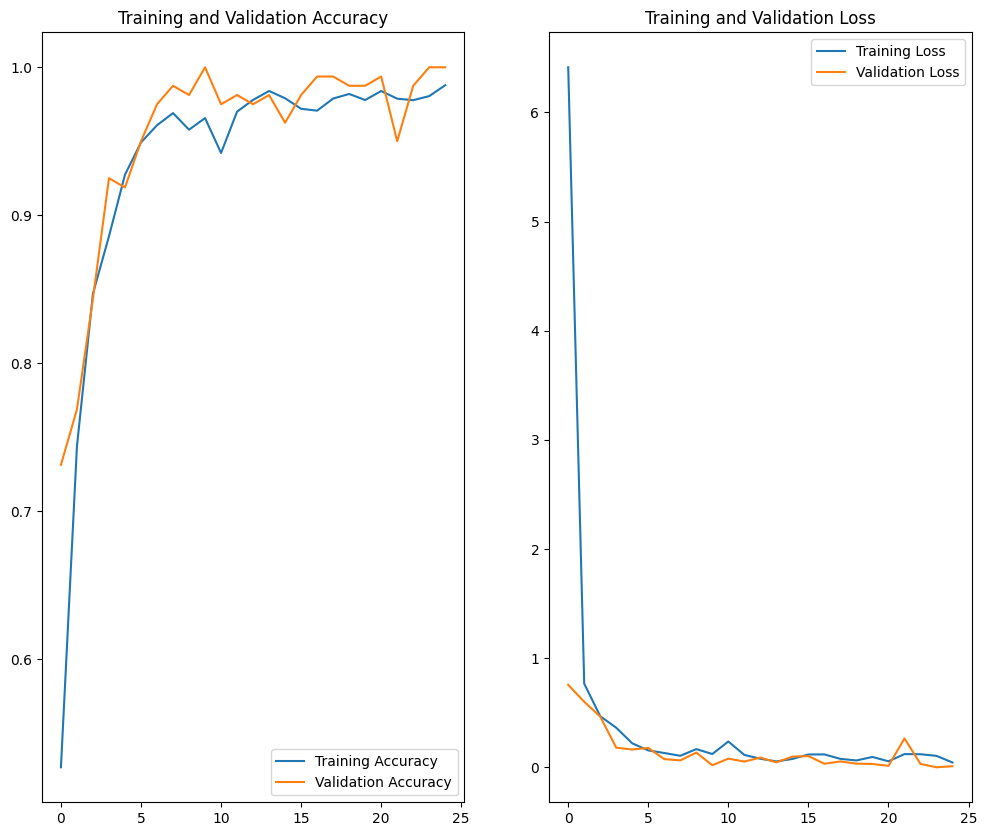

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=(12, 10))
plt.subplot(1, 2, 1)
plt.plot(range(25), acc, label='Training Accuracy')
plt.plot(range(25), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(range(25), loss, label='Training Loss')
plt.plot(range(25), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')


In [24]:
def sample_predict(model, image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions)
    try:
        predicted_class = class_names[predicted_class_index]
    except NameError:
        raise NameError("Please define `class_names` as a list of class labels before calling this function.")
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    print("Predicted class:", predicted_class)



1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


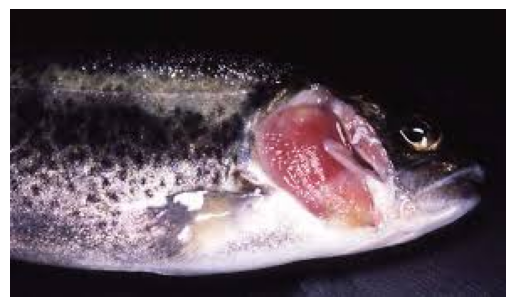

Predicted class: Bacterial gill disease
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


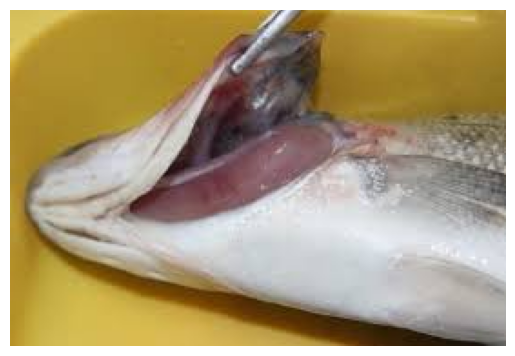

Predicted class: Bacterial gill disease
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


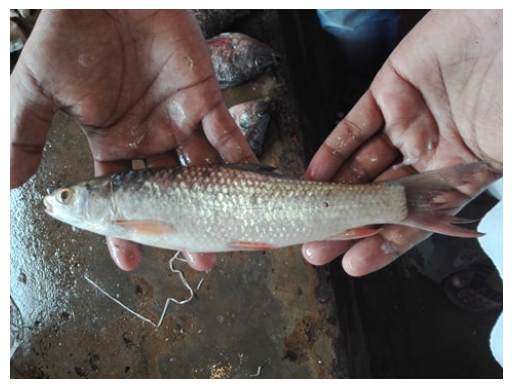

Predicted class: Healthy Fish
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


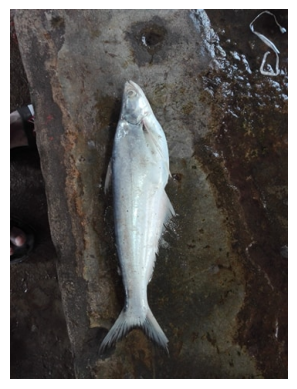

Predicted class: Healthy Fish
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


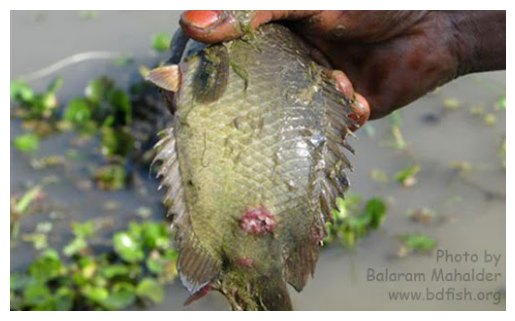

Predicted class: Bacterial Red disease
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


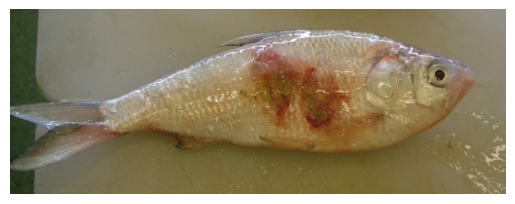

Predicted class: Bacterial Red disease


In [25]:
#images taken from different dataset
sample_predict(model, "/content/gill rot 1.jpg")
sample_predict(model, "/content/gill rot 2.jpg")
sample_predict(model,"/content/healthy 1.jpg")
sample_predict(model,"/content/healthy 2.jpg")
sample_predict(model,"/content/red spot 1.jpg")
sample_predict(model,"/content/red spot 2.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


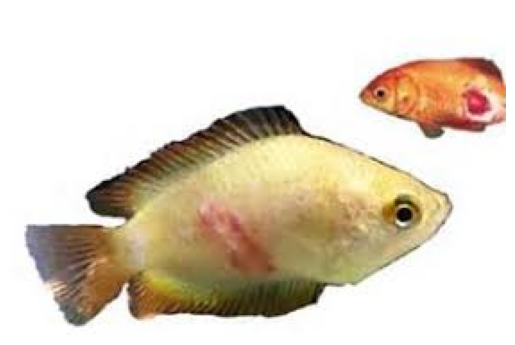

Predicted class: Bacterial diseases - Aeromoniasis
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


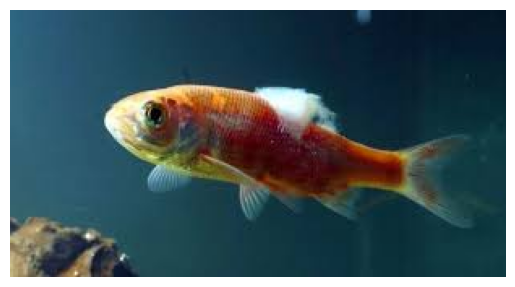

Predicted class: Fungal diseases Saprolegniasis
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


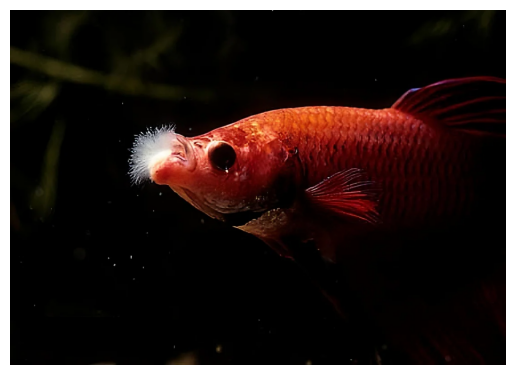

Predicted class: Fungal diseases Saprolegniasis
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


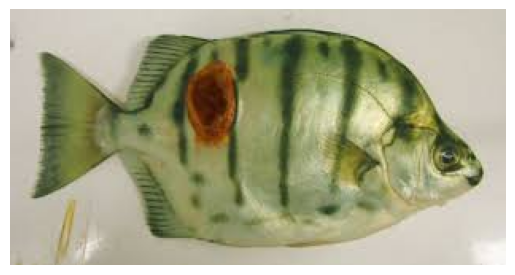

Predicted class: Bacterial Red disease


In [27]:
#taken from the internet
sample_predict(model, "/content/aeromonisias 2.jpg")
sample_predict(model, "/content/fungal 1.jpg")
sample_predict(model, "/content/fungal 2.webp")
sample_predict(model, "/content/red spot 3.jpg")

